In [2]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW, lr_scheduler as LRScheduler

from transformers import get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate,
    train,
    evaluate_weightless,
    train_weightless,
    EarlyStopper,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric_key = "weighted_median"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [3]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021, 2022]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}_{metric_key}"]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= 2022]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [4]:
eval_df

,unit_price_wmedian_pct_chg,unit_price_wmedian,year,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,total_tax,total_tax_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,area_code,normalized_unit_price_wmedian_pct_chg
20825,-0.636983,5334.749823,2021,14.0,5060.0,19497.0,7373.0,19995635.0,2712.008002,0.036516,0.041718,1787679.0,-0.027790,0.0,0.0,-0.005334,0.000000,1,1,0,1,38506,-0.844747
20826,1.107922,82973.663522,2021,48.0,13985.0,31309.0,13458.0,45115124.0,3352.290385,0.104013,0.095809,3812027.0,0.001491,0.0,0.0,0.004216,0.000000,1,1,0,1,29363,0.833447
20827,-0.710890,2359.245035,2021,3.0,2550.0,5474.0,1595.0,3889373.0,2438.478370,0.069192,0.026291,436440.0,0.002030,0.0,0.0,-0.007855,0.000000,1,1,0,1,46531,-0.915828
20828,0.035482,108634.717191,2021,146.0,39630.0,150551.0,72678.0,239596333.0,3296.683082,0.027892,0.030819,22916366.0,-0.009408,961.0,69088.0,-0.000206,0.013910,1,1,1,1,11232,-0.197991
20829,-0.402726,21988.410557,2021,29.0,11910.0,31375.0,14611.0,42484876.0,2907.732257,0.021347,0.031413,3583305.0,-0.020179,172.0,16613.0,-0.008159,0.010353,1,1,1,1,37204,-0.619446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24082,-0.531168,19132.231405,2022,46.0,14335.0,41181.0,0.0,0.0,0.000000,0.000000,0.000000,5846716.0,0.029604,0.0,0.0,-0.001384,0.000000,1,0,0,1,28205,-0.728555
24083,0.135683,246064.746065,2022,657.0,117760.0,648482.0,0.0,0.0,0.000000,0.000000,0.000000,105489851.0,0.036020,0.0,0.0,0.004551,0.000000,1,0,0,1,12204,-0.114221
24084,1.037457,41306.726746,2022,57.0,27880.0,104274.0,0.0,0.0,0.000000,0.000000,0.000000,15894260.0,0.003834,0.0,0.0,-0.003942,0.000000,1,0,0,1,38206,0.716535
24085,-0.788630,1136.363636,2022,2.0,440.0,3670.0,0.0,0.0,0.000000,0.000000,0.000000,310907.0,-0.010156,0.0,0.0,-0.014986,0.000000,1,0,0,1,36383,-0.965741


In [5]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
    "total_tax",
    "total_tax_growth",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

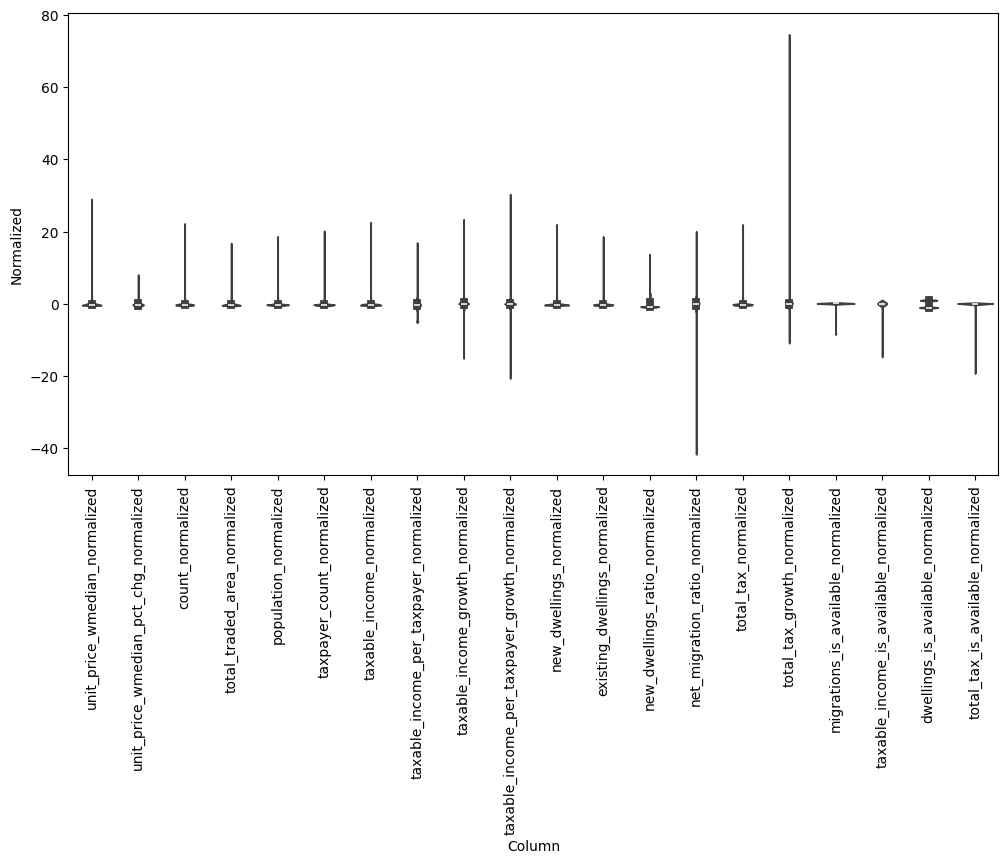

In [6]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [7]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# To account for years where the data is not available and all the values are zero. In those situations, the normalized values will be NaN.
df = df.fillna(0)

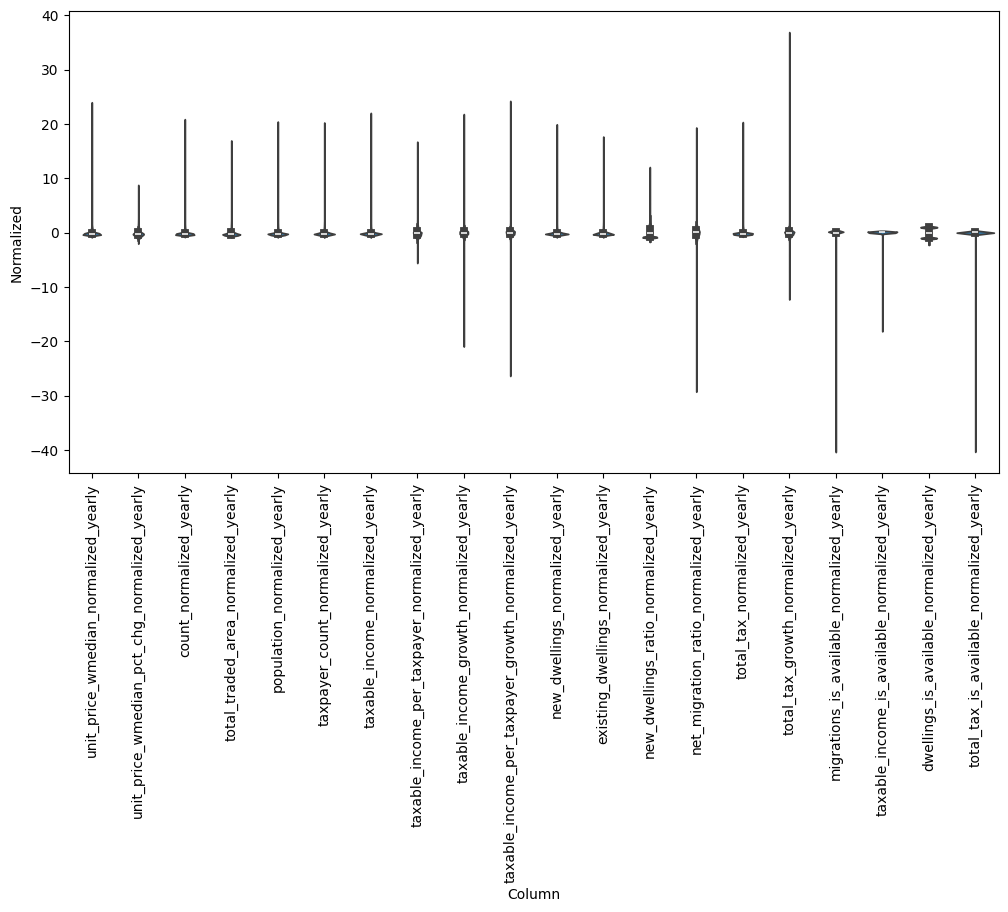

In [8]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [9]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly + ["migrations_is_available", "taxable_income_is_available", "dwellings_is_available"]

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 24) (1,) [-0.65463731] [1.81092244]
1 (0, 24) (1,) [-1.77727301] [1.01376778]
2 (0, 24) (1,) [0.68058217] [1.05851308]
3 (0, 24) (1,) [-1.31425438] [1.02340523]
0 torch.Size([5, 24]) torch.Size([1]) tensor([-0.6546]) tensor([1.8109])
1 torch.Size([5, 24]) torch.Size([1]) tensor([-1.7773]) tensor([1.0138])
2 torch.Size([5, 24]) torch.Size([1]) tensor([0.6806]) tensor([1.0585])
3 torch.Size([5, 24]) torch.Size([1]) tensor([-1.3143]) tensor([1.0234])


In [10]:
BATCH_SIZE = 256

In [11]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24087 entries, 0 to 24086
Data columns (total 64 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   unit_price_wmedian_pct_chg                            24087 non-null  float64
 1   unit_price_wmedian                                    24087 non-null  float64
 2   year                                                  24087 non-null  int64  
 3   count                                                 24087 non-null  float64
 4   total_traded_area                                     24087 non-null  float64
 5   population                                            24087 non-null  float64
 6   taxpayer_count                                        24087 non-null  float64
 7   taxable_income                                        24087 non-null  float64
 8   taxable_income_per_taxpayer                           24

### Building the Transformer Model

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [14]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [15]:
%%timeit

model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 1.069401741027832
torch.Size([256, 5, 24]) torch.Size([256, 5]) torch.Size([256, 1]) to

In [16]:
# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping and regularization so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary

def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

# loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
# model.load_state_dict(loaded_state_dict, strict=False)


In [17]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 200

In [18]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [19]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 4.0688, Eval Loss: 3.7379
Train R^2: -0.0105, Eval R^2: 0.0714
Epoch: 1
Train Loss: 3.6163, Eval Loss: 3.5020
Train R^2: 0.1002, Eval R^2: 0.1312
Epoch: 2
Train Loss: 3.5293, Eval Loss: 3.4647
Train R^2: 0.1220, Eval R^2: 0.1399
Epoch: 3
Train Loss: 3.4854, Eval Loss: 3.4049
Train R^2: 0.1329, Eval R^2: 0.1537
Epoch: 4
Train Loss: 3.4558, Eval Loss: 3.3719
Train R^2: 0.1401, Eval R^2: 0.1614
Epoch: 5
Train Loss: 3.4351, Eval Loss: 3.3574
Train R^2: 0.1452, Eval R^2: 0.1649
Epoch: 6
Train Loss: 3.4180, Eval Loss: 3.3458
Train R^2: 0.1494, Eval R^2: 0.1678
Epoch: 7
Train Loss: 3.4120, Eval Loss: 3.3497
Train R^2: 0.1509, Eval R^2: 0.1668
Epoch: 8
Train Loss: 3.4214, Eval Loss: 3.3907
Train R^2: 0.1488, Eval R^2: 0.1567
Epoch: 9
Train Loss: 3.4095, Eval Loss: 3.3904
Train R^2: 0.1517, Eval R^2: 0.1567
Epoch: 10
Train Loss: 3.3822, Eval Loss: 3.3921
Train R^2: 0.1584, Eval R^2: 0.1562
Epoch: 11
Train Loss: 3.3639, Eval Loss: 3.3960
Train R^2: 0.1629, Eval R^2: 0.1553
E

KeyboardInterrupt: 

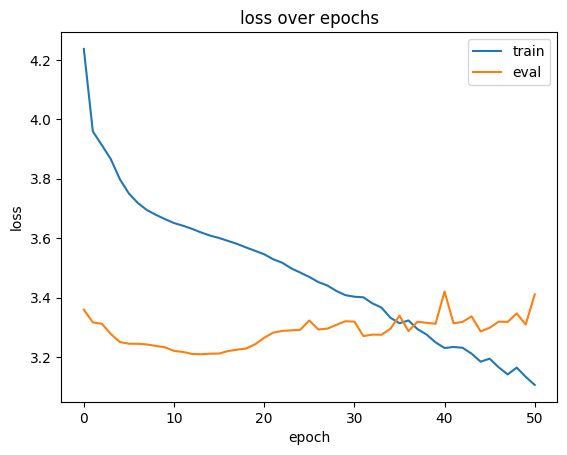

In [210]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

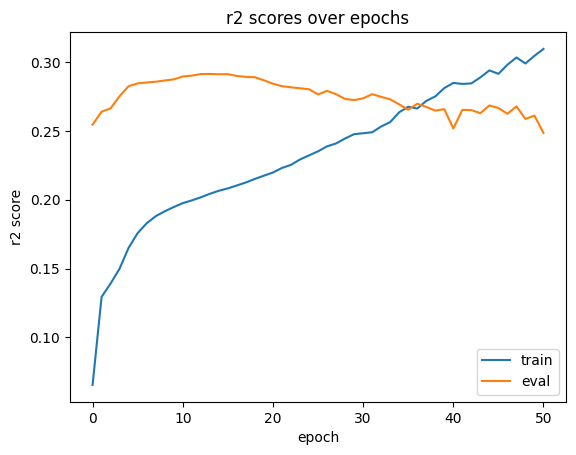

In [211]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [32]:
# untrained model
loss, epoch_r2_score = evaluate(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.4521
Eval R2: 0.1688


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

### The High Variance Problem

The model is overfitting right now